# Time Series Forecasting System
Time Series is a big component of our everyday lives. They are in fact used in medicine (EEG analysis), finance (Stock Prices) and electronics (Sensor Data Analysis). Many Machine Learning models have been created in order to tackle these types of tasks, two examples are ARIMA (AutoRegressive Integrated Moving Average) models and RNNs (Recurrent Neural Networks).


# Data Source

For Time series analysis, we are going to deal with Stock market Analysis. This dataset is based US-based stocks daily price and volume data.
Dataset taken for analysis is IBM stock market data from 2006-01-01 to 2018-01-01.

Below are the key fields in the dataset:

__`Date, Open, High, Low, Close, Volume, Name`__

# Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load Data

In [2]:
df = pd.read_csv("IBM_2006-01-01_to_2018-01-01.csv.zip")
df.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
1,2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2,2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
3,2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
4,2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


In [3]:
print(df.shape)
print(df.columns)

(3020, 7)
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Name'], dtype='object')


In [4]:
# Cleaning up the data
df.isnull().values.any()
df = df.dropna()
df.shape

(3019, 7)

In [5]:
df.index = pd.to_datetime(df['Date'])
df.head()

,Date,Open,High,Low,Close,Volume,Name
Date,,,,,,,
2006-01-03,2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
2006-01-04,2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2006-01-05,2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
2006-01-06,2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
2006-01-09,2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


# Note
This dataset is composed of different features.We will just examine the “Open” stock prices feature. This same analysis can be repeated for most of the other features.

# Visualization

### Visualizing the High and Low prices of IBM

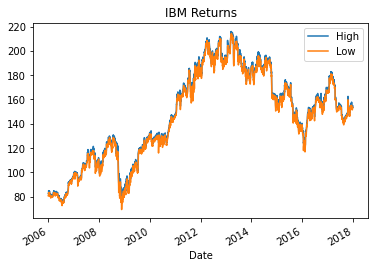

In [6]:
dr = df[['High', 'Low']]
dr.plot()
plt.title('IBM Returns');

### Q1: Visualize the Open and Close prices of IBM

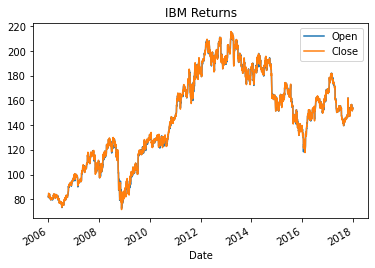

In [7]:
dr = df[['Open', 'Close']]
dr.plot()
plt.title('IBM Returns');

### Q2: Visualize the Open and Close Cumulative Prices of IBM

                 Open      Close
Date                            
2006-01-03      82.45      82.06
2006-01-04     164.65     164.01
2006-01-05     246.05     246.51
2006-01-06     330.00     331.46
2006-01-09     414.10     415.19
...               ...        ...
2017-12-22  438698.60  439006.09
2017-12-26  438851.11  439158.92
2017-12-27  439004.06  439312.05
2017-12-28  439157.26  439466.09
2017-12-29  439311.43  439619.51

[3019 rows x 2 columns]


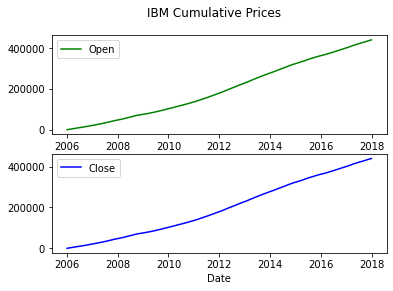

In [35]:
dr = df[['Open', 'Close']]
sums = dr.cumsum(axis = 0)
print(sums)

fig, (ax1, ax2) = plt.subplots(2)

fig.suptitle('IBM Cumulative Prices')
ax1.set_xlabel('Date')
ax1.plot(sums['Open'], 'green', label='Open')
ax1.legend()

ax2.set_xlabel('Date')
ax2.plot(sums['Close'], 'blue', label='Close')
ax2.legend()


####  Before we start working on Time Series forecasting, Let's analyse the autocorrelation plot of the “Open” feature with respect to a few lag values

### Auto-correlation plot with Lag 1

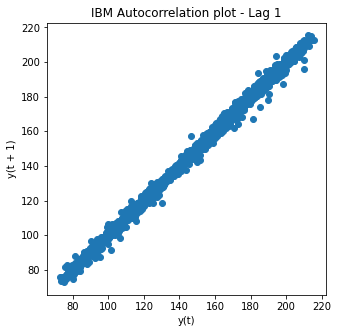

In [36]:
# START_CODE_HERE - plot the Autocorrelation plot for feature 'Open'
from pandas.plotting import lag_plot

plt.figure(figsize=(5,5))
lag_plot(df['Open'], lag=1)
plt.title('IBM Autocorrelation plot - Lag 1');
# END_CODE_HERE

### Q3: Visualize the Auto-Correlation plot for IBM Open prices with Lag 5 

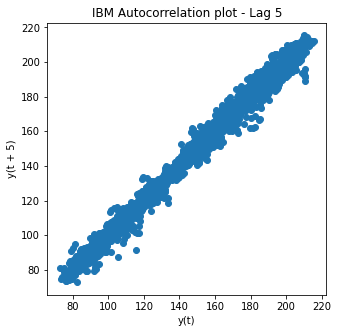

In [37]:
# START_CODE_HERE - plot the Autocorrelation plot for feature 'Open'
from pandas.plotting import lag_plot

plt.figure(figsize=(5,5))
lag_plot(df['Open'], lag=5)
plt.title('IBM Autocorrelation plot - Lag 5');
# END_CODE_HERE

We see a definite linear trend in the auto-correlation plot telling us there is some correlation in prices with respect to prices from previous 1 / 5 days of lag which sets up the stage of forecasting future prices based on past price data 

## Build Train-Test Datasets

#### Now, Let's divide the data into a training and test set. Once done so, we can plot both on the same figure in order to get a feeling of how does our Time Series looks like

In [38]:
train_data, test_data = df.iloc[0:int(len(df)*0.8), :], df.iloc[int(len(df)*0.8):, :]

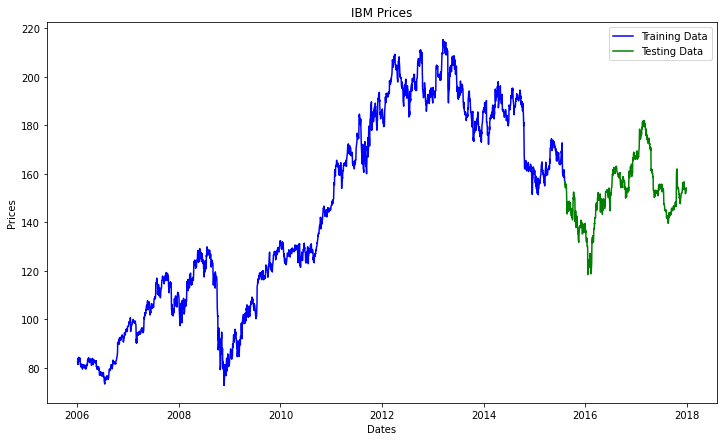

In [39]:
plt.figure(figsize=(12,7))
plt.title('IBM Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(train_data['Open'], 'blue', label='Training Data')
plt.plot(test_data['Open'], 'green', label='Testing Data')
plt.legend();

# ARIMA (AutoRegressive Integrated Moving Average)

The acronym of ARIMA stands for:

AutoRegressive(AR) = the model takes advantage of the connection between a predefined number of lagged observations and the current one.

Integrated(I) = differencing between raw observations (eg. subtracting observations at different time steps).

Moving Average(MA) = the model takes advantage of the relationship between the residual error and the observations.

The ARIMA model makes use of three main parameters (p,d,q). These are:

p = number of lag observations.

d = the degree of differencing.

q = the size of the moving average window.



## Understaning the ARIMA Model

### the ARIMA parameters - used to help model the major aspects of a times series: seasonality, trend, and noise. These parameters are labeled p,d,and q. You have already learnt a fair bit of this in the curriculum but following is a brief refresher.

__p:__ is the parameter associated with the auto-regressive aspect of the model, which incorporates past values. For example, forecasting that if it rained a lot over the past few days, you state its likely that it will rain tomorrow as well.

__d:__ is the parameter associated with the integrated part of the model, which effects the amount of differencing to apply to a time series. You can imagine an example of this as forecasting that the amount of rain tomorrow will be similar to the amount of rain today, if the daily amounts of rain have been similar over the past few days.

__q:__ is the parameter associated with the moving average part of the model.

### Approach to determine the parameters
There are many ways to choose these values statistically, such as looking at auto-correlation plots, correlation plots, domain experience, etc.

Another approach is to perform a grid search over multiple values of p,d,q using some sort of performance criteria. The Akaike information criterion (AIC) is an estimator of the relative quality of statistical models for a given set of data. Given a collection of models for the data, AIC estimates the quality of each model, relative to each of the other models.


In this exercise, we will look into the statistical method of getting these values from auto-correlation and correlation plots.

### Stationarity of the data - Determine the d value

Stationarity typically indicates various statistical measures of the time series do not change over time. Thus, a time series is stationary when its mean, variance and auto-correlation, etc., are constant over time. 

Most time-series forecasting models typically perform well when the series is stationary and hence it is important to find out if your time-series dataset is stationary. 

ARIMAs that include differencing (i.e., d > 0) assume that the data becomes stationary after differencing. This is called difference-stationary. 

Auto-correlation plots are an easy way to determine whether your time series is sufficiently stationary for modeling. 

If the plot does not appear relatively stationary, your model will likely need a differencing term. 

The Augmented Dickey-Fuller test is an important statistical test which we will use to prove if the series is stationary or not and take necessary steps in case it is not stationary.

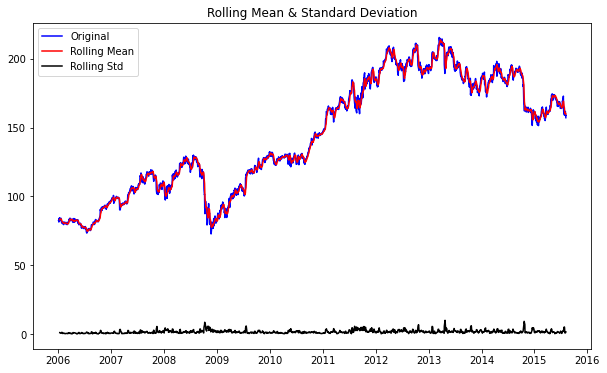

In [40]:
window = 7
train_series = train_data['Open']

#Determing rolling statistics
rolmean = train_series.rolling(window).mean()
rolstd = train_series.rolling(window).std()

#Plot rolling statistics:
fig = plt.figure(figsize=(10, 6))
orig = plt.plot(train_series, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation');
    

In [41]:
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(train_series, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
dfoutput

Test Statistic                   -1.487786
p-value                           0.539545
#Lags Used                        7.000000
Number of Observations Used    2407.000000
Critical Value (1%)              -3.433070
Critical Value (5%)              -2.862742
Critical Value (10%)             -2.567410
dtype: float64

If the p-value is small beyond a specific significance level threshold, let's consider that to be a standard value of 0.05, then we can say the series is stationary. F

rom the above statistics, we can observe that the p-value is 0.539 which proves that our series is not stationary.

To get stationary data, there are many techniques. We can use log, differencing and so on. Let's use a first order differencing here.

### Q4: Apply a first order differencing on the training data

Hint: Check out the __`diff()`__ function in pandas and try using it on the __`train_series`__ dataset

In [42]:
train_diff = train_series.diff()
train_diff = train_diff.dropna(inplace = False)
print(train_diff)

Date
2006-01-04   -0.25
2006-01-05   -0.80
2006-01-06    2.55
2006-01-09    0.15
2006-01-10   -0.95
              ... 
2015-07-31    0.90
2015-08-03    0.30
2015-08-04   -3.30
2015-08-05    0.70
2015-08-06   -1.97
Name: Open, Length: 2414, dtype: float64


### Q5: Visualize Rolling statistics for differenced train data

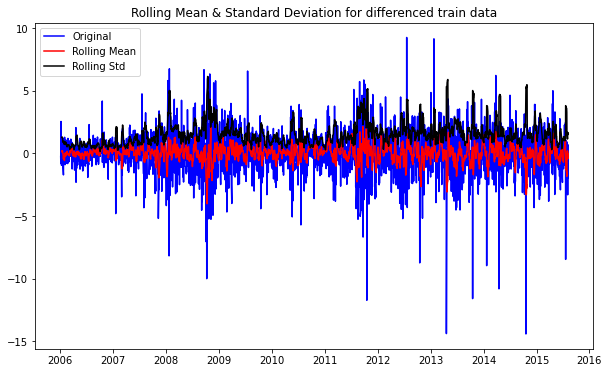

In [43]:
window = 7

#Determing rolling statistics

#Determing rolling statistics
rolmean = train_diff.rolling(window).mean()
rolstd = train_diff.rolling(window).std()

#Plot rolling statistics:
fig = plt.figure(figsize=(10, 6))
orig = plt.plot(train_diff, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation for differenced train data');    

### Q6: Compute AD-Fuller Stats for differenced train data

In [44]:
dftest = adfuller(train_diff, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
dfoutput

Test Statistic                  -20.324277
p-value                           0.000000
#Lags Used                        6.000000
Number of Observations Used    2407.000000
Critical Value (1%)              -3.433070
Critical Value (5%)              -2.862742
Critical Value (10%)             -2.567410
dtype: float64

After differencing, the p-value is extremely small. Thus this series is very likely to be stationary.

### ACF Plots (Auto Correlation Function):
ACF is an auto-correlation function which gives us correlation of any series with its lagged values(previous timestep values).

ACF plot describes the correlation of the current value with the previous lagged values(specified by *lags*).

For example, how the dependency chain is followed as direct dependency .... $S_{t-2} --> S_{t-1} --> S_t$*

Also, ACF finds correlation between $S_{t-2} --> S_t$ (indirect dependency).

* --> = represents dependency

#### Limitation: 
ACF is not very accurate as indirect dependency is affected by direct dependency and so the plots are always above the confidence band(as shown below).

### PACF Plots: Pearson Auto Correlation Function:
PACF plots models the indirect dependencies and is not affected by the direct dependencies.

$S_{t-2} --> S_t$

From the below example we can see how today's value is affected by the last 10 days. 

The points that lie inside the blue confidence band do not correlate with or affect today's value. In ACF, we saw that all values are above the confidence band(as $S_{t-2} --> S{t}$ is affected by $S_{t-1} --> S_t$), which is not a good representation of the correlation.


In PACF, indirect dependencies are modelled well.

## ACF and PACF - AR and MA Intuition
The partial autocorrelation at lag k is the correlation that results after removing the effect of any correlations due to the terms at shorter lags.

### Autoregression Intuition
Consider a time series that was generated by an autoregression (AR) process with a lag of k.

We know that the ACF describes the autocorrelation between an observation and another observation at a prior time step that includes direct and indirect dependence information.

This means we would expect the ACF for the AR(k) time series to be strong to a lag of k and the inertia of that relationship would carry on to subsequent lag values, trailing off at some point as the effect was weakened.

We know that the PACF only describes the direct relationship between an observation and its lag. This would suggest that there would be no correlation for lag values beyond k.

This is exactly the expectation of the ACF and PACF plots for an AR(k) process.

### Moving Average Intuition
Consider a time series that was generated by a moving average (MA) process with a lag of k.

Remember that the moving average process is an autoregression model of the time series of residual errors from prior predictions. Another way to think about the moving average model is that it corrects future forecasts based on errors made on recent forecasts.

We would expect the ACF for the MA(k) process to show a strong correlation with recent values up to the lag of k, then a sharp decline to low or no correlation. By definition, this is how the process was generated.

For the PACF, we would expect the plot to show a strong relationship to the lag and a trailing off of correlation from the lag onwards.

Again, this is exactly the expectation of the ACF and PACF plots for an MA(k) process.

### Plot ACF and PACF on the original train series

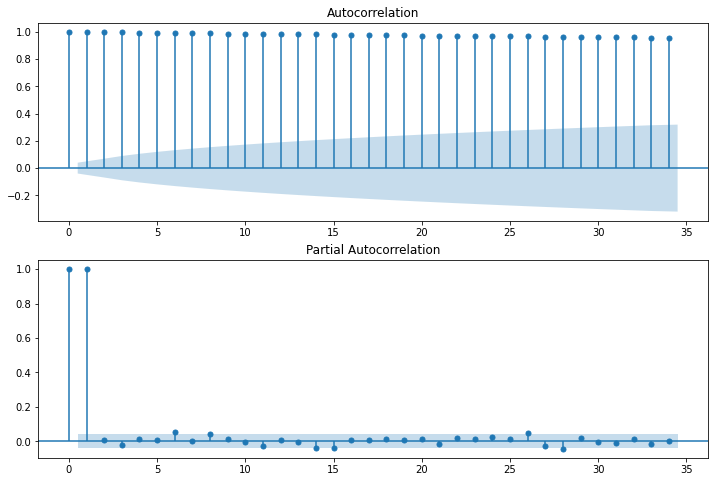

In [45]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, 1, figsize=(12,8))
plot_acf(train_series, ax=ax[0]); # 
plot_pacf(train_series, ax=ax[1]);

### Q7: Plot ACF and PACF on the differenced train series

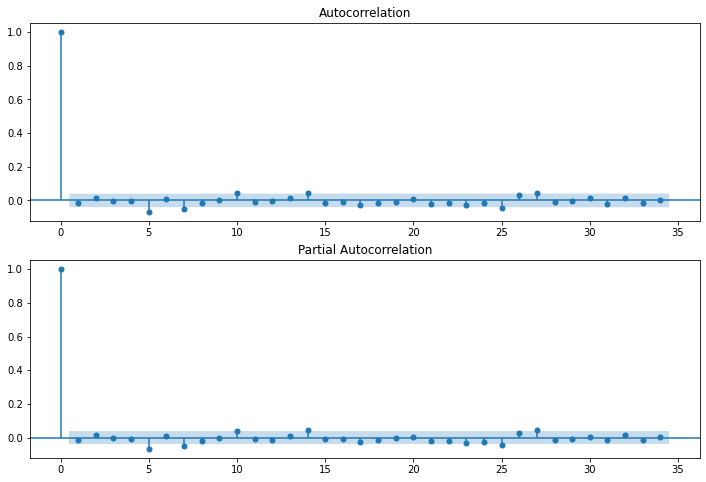

In [46]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, 1, figsize=(12,8))
plot_acf(train_diff, ax=ax[0]); # 
plot_pacf(train_diff, ax=ax[1]);

# How to determine p, d, q

It's easy to determine d. In our case, we see the first order differencing make the ts stationary. Hence d = 1

AR model might be investigated first with lag length selected from the PACF or via empirical investigation. In our case, it's clearly that within 5 lags the AR is significant. Which means, we can use AR = 5 i.e, p = 5

To avoid the potential for incorrectly specifying the MA order to be too high we set MA = 0 i.e q = 0 by taking a look at the ACF plot though we do have a value of 5 which is significant considering the interval but we start off with the first lag value i.e q = 0.

Hence:

- p=5
- d=1
- q=0

# Evaluation of ARIMA Model

In order to evaluate the ARIMA model,we can use two different error functions:

- Mean Squared Error (MSE)
- Symmetric Mean Absolute Percentage Error (SMAPE)

SMAPE is commonly used as an accuracy measure based on relative errors

### SMAPE

![](imgs/smape.png)

SMAPE is not currently supported in Scikit-learn as a loss function, therefore we first create this function.

In [47]:
def smape_kun(y_true, y_pred):
    # START_CODE_HERE
    return np.mean((np.abs(y_pred - y_true) * 200 / (np.abs(y_pred) + np.abs(y_true))))
    # END_CODE_HERE

### Q8: Difference the Test Series

In [48]:
test_series = test_data['Open']

test_diff = test_series.diff()
test_diff = test_diff.dropna(inplace = False)
print(test_diff)

Date
2015-08-10    0.88
2015-08-11   -0.81
2015-08-12   -1.70
2015-08-13    1.80
2015-08-14   -1.06
              ... 
2017-12-22   -1.35
2017-12-26    0.69
2017-12-27    0.44
2017-12-28    0.25
2017-12-29    0.97
Name: Open, Length: 603, dtype: float64


### Q9: Train and Forecast using ARIMA Model by filling in the necessary blocks

Note: Here we will use a rolling point-based prediction for the ARIMA model where we tried to predict every day's (t) stock price in the test data by using both the training data as well as the previous (n - t) days of test data also to fit the model.
Of course this is not the only way for forecasting and you can do it in multiple ways e.g just use train data to forecast, use a window of days to forecast including test data and so on.

In [49]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

In [58]:
%%time 

history = [x for x in train_diff]

predictions = list()
for t in range(len(test_diff)):

    # START_CODE_HERE - call the ARIMA Method with history and params
    
    model = ARIMA(history, order=(5,1,0)) # initialize the model with history and right order of parameters
    model_fit = model.fit()  # fit the model
    if t % 100 == 0:
        print(model_fit.summary())

    # END_CODE_HERE

    # Forecast
    output = model_fit.forecast()  # use forecast on the fitted model
    yhat = output[0][0]
    predictions.append(yhat)

    obs = test_diff[t]
    history.append(obs)

    if t % 100 == 0:
      print('Test Series Point: {}\tPredicted={}, Expected={}'.format(t, yhat, obs))

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 2413
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -5065.650
Method:                       css-mle   S.D. of innovations              1.974
Date:                Sun, 01 Aug 2021   AIC                          10145.301
Time:                        11:20:26   BIC                          10185.821
Sample:                             1   HQIC                         10160.038
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.012     -0.038      0.969      -0.023       0.023
ar.L1.D.y     -0.8265      0.020    -41.378      0.000      -0.866      -0.787
ar.L2.D.y     -0.6365      0.025    -25.076      0.0

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 2813
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -5906.185
Method:                       css-mle   S.D. of innovations              1.975
Date:                Sun, 01 Aug 2021   AIC                          11826.370
Time:                        11:22:51   BIC                          11867.964
Sample:                             1   HQIC                         11841.380
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.011     -0.028      0.977      -0.022       0.021
ar.L1.D.y     -0.8249      0.018    -44.669      0.000      -0.861      -0.789
ar.L2.D.y     -0.6370      0.023    -27.187      0.0

### Reverse Transform the forecasted values

This is very important. Since we used differencing of the first order in the series before training, we need to reverse transform the values to get meaningful price forecasts.

In [59]:
reverse_test_diff = np.r_[test_series.iloc[0], test_diff].cumsum()
reverse_predictions = np.r_[test_series.iloc[0], predictions].cumsum()
reverse_test_diff.shape, reverse_predictions.shape

((604,), (604,))

### Evaluate model performance

In [60]:
error = mean_squared_error(reverse_test_diff, reverse_predictions)
print('Testing Mean Squared Error: %.3f' % error)
error2 = smape_kun(reverse_test_diff, reverse_predictions)
print('Symmetric Mean absolute percentage error: %.3f' % error2)

Testing Mean Squared Error: 18.258
Symmetric Mean absolute percentage error: 2.445


The loss results for this model are available above. According to the MSE, the model loss is quite low but for SMAPE is instead consistently higher. One of the main reason for this discrepancy is because SMAPE is commonly used loss a loss function for Time Series problems and can, therefore, provide a more reliable analysis. That showed there is still room for improvement of our model.

## Let's Visualize the forecast results

In [61]:
reverse_test_diff_series = pd.Series(reverse_test_diff)
reverse_test_diff_series.index = test_series.index

reverse_predictions_series = pd.Series(reverse_test_diff)
reverse_predictions_series.index = test_series.index

### Visualizing train, test and forecast prices

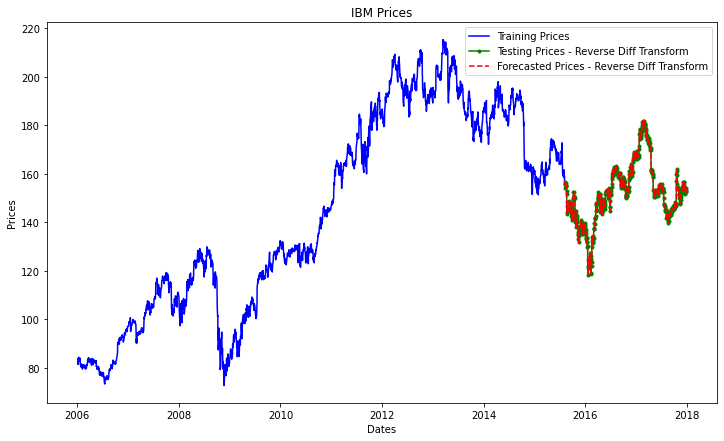

In [62]:
plt.figure(figsize=(12,7))
plt.title('IBM Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(train_series, color='blue', label='Training Prices')
plt.plot(reverse_test_diff_series, color='green', marker='.', label='Testing Prices - Reverse Diff Transform')
plt.plot(reverse_test_diff_series, color='red', linestyle='--', label='Forecasted Prices - Reverse Diff Transform')
plt.legend();

### Q10: Visualize only test and forecast prices

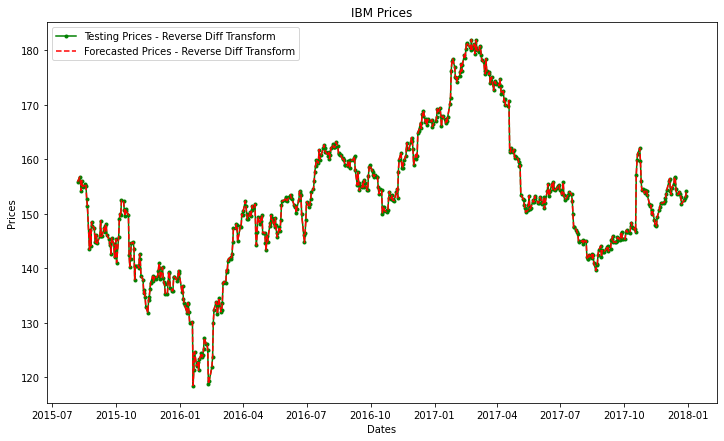

In [63]:
plt.figure(figsize=(12,7))
plt.title('IBM Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(reverse_test_diff_series, color='green', marker='.', label='Testing Prices - Reverse Diff Transform')
plt.plot(reverse_test_diff_series, color='red', linestyle='--', label='Forecasted Prices - Reverse Diff Transform')
plt.legend();

This analysis using ARIMA has performed pretty well in forecasting prices 

# Time Series Forecasting with Deep Learning

The approach uses sequential models, to be more specific - LSTMs, to build a deep learning model that predicts the 'Open' Stock prices of IBM over a period of two years by using data from the previous 10 years.

### LSTM: A brief overview

What are LSTMs? : https://medium.com/deep-math-machine-learning-ai/chapter-10-1-deepnlp-lstm-long-short-term-memory-networks-with-math-21477f8e4235

Long short-term memory (LSTM) units (or blocks) are a building unit for layers of a recurrent neural network (RNN). A RNN composed of LSTM units is often called an LSTM network. A common LSTM unit is composed of a cell, an input gate, an output gate and a forget gate. The cell is responsible for "remembering" values over arbitrary time intervals; hence the word "memory" in LSTM. Each of the three gates can be thought of as a "conventional" artificial neuron, as in a multi-layer (or feedforward) neural network: that is, they compute an activation (using an activation function) of a weighted sum. Intuitively, they can be thought as regulators of the flow of values that goes through the connections of the LSTM; hence the denotation "gate". There are connections between these gates and the cell.

The expression long short-term refers to the fact that LSTM is a model for the short-term memory which can last for a long period of time. An LSTM is well-suited to classify, process and predict time series given time lags of unknown size and duration between important events. LSTMs were developed to deal with the exploding and vanishing gradient problem when training traditional RNNs.

Source: [Wikipedia](https://en.wikipedia.org/wiki/Long_short-term_memory)

### Headers

In [65]:
# Let's load the libraries and dependencies for the deep learning model
from sklearn.preprocessing import MinMaxScaler

# Oops, this magic function only works in Google colab
#%tensorflow_version 1.x
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD

### Load Data

In [67]:
df = pd.read_csv("IBM_2006-01-01_to_2018-01-01.csv.zip")
df.isnull().values.any()
df = df.dropna()

df.index = pd.to_datetime(df['Date'])
df.head()

,Date,Open,High,Low,Close,Volume,Name
Date,,,,,,,
2006-01-03,2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
2006-01-04,2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2006-01-05,2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
2006-01-06,2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
2006-01-09,2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


# Note
This dataset is composed of different features.we will just examine the "Open" stock prices feature. This same analysis can be repeated for most of the other features.

## Build Train-Test Datasets

In [68]:
# Splitting the train and test set considering 'Open' feature from the dataset
train_data, test_data = df.iloc[0:int(len(df)*0.8), :], df.iloc[int(len(df)*0.8):, :]
train_series = train_data['Open']
test_series = test_data['Open']
train_series.shape, test_series.shape

((2415,), (604,))

### Q11: Visualize train and test price data

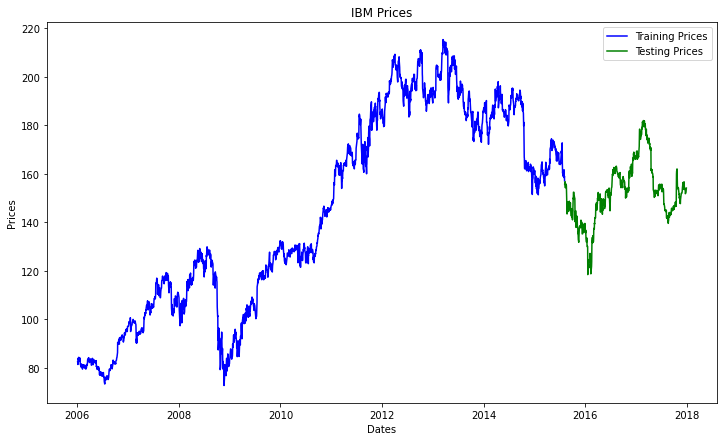

In [69]:
plt.figure(figsize=(12,7))
plt.title('IBM Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(train_series, color='blue', label='Training Prices')
plt.plot(test_series, color='green', label='Testing Prices')
plt.legend();

### Scaling
As stock prices can vary across a wide range, we scale the data to have zero mean and unit variance.

This is done to ensure that the gradient descent is sooner when learning a deep learning model

### Q12: Use the initialized min-max scaler to scale the prices in train_series

In [90]:
sc = MinMaxScaler(feature_range=(0,1))
# START_CODE_HERE
df = pd.DataFrame(train_series)
training_set_scaled = sc.fit_transform(df)
# END_CODE_HERE

In [91]:
training_set_scaled.shape

(2415, 1)

In [104]:
#1 output and 60 values inputs
# So for each element of training set (output), we have 60 previous training set elements (input)

X_train = []
y_train = []
for i in range(60, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape, y_train.shape

((2355, 60), (2355,))

#### Reshape X_train

Now we reshape X_train in the format like:

(batch_size, timesteps, input_dim) => (m, features, $x_{i1}$)

The X_train should be now: (2709, 60, 1)

60 features = 60 day sliding window

$x_{i1}$ = 1 data point for each feature and i represents the feature



In [105]:
# Reshaping X_train for efficient modeling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1], 1))

In [106]:
X_train.shape

(2355, 60, 1)

### LSTM Regression model

We use  [LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM):
*   units - output dimensions
*   return_sequences is set to True to get all the hidden state vectors information

The model uses 2 LSTM layers followed by a Dense Layer with a single neuron to output regression prediction.

#### Similar Model Architecture (dimensions not exact)

![Similar Model Architecture](imgs/lstm.png)


### Q13: Build the LSTM based forecasting DL Model architecture

Hints:

    - Fill the second LSTM layer using an LSTM cell with 64 units, remember NOT to set return_sequences to True as we are only concerned about passing the last sequence output to the next layer
    - Fill the Output layer with 1 unit
    - Compile the model with mentioned optimizer and loss values

In [162]:
regressor = Sequential()
loss = 'mse'
optimizer = 'rmsprop'

# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))

# Second LSTM layer
regressor.add(LSTM(units=64))
regressor.add(Dropout(0.2))

# The output layer
regressor.add(Dense(1))

# Compiling the RNN - optimizer(rmsprop)and loss(mean squared error)
regressor.compile(
    loss=loss,
    optimizer=optimizer,   
)

regressor.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 60, 64)            16896     
_________________________________________________________________
dropout_11 (Dropout)         (None, 60, 64)            0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dropout_12 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________


### Train the model

In [163]:
regressor.fit(X_train,y_train, epochs=15, batch_size=64, validation_split=0.1, shuffle=False)

Epoch 1/15
34/34 [==============================] - 3s 45ms/step - loss: 0.0121 - val_loss: 0.0108
Epoch 2/15
34/34 [==============================] - 1s 34ms/step - loss: 0.0096 - val_loss: 0.0068
Epoch 3/15
34/34 [==============================] - 1s 34ms/step - loss: 0.0077 - val_loss: 0.0104
Epoch 4/15
34/34 [==============================] - 1s 34ms/step - loss: 0.0080 - val_loss: 0.0066
Epoch 5/15
34/34 [==============================] - 1s 34ms/step - loss: 0.0067 - val_loss: 0.0099
Epoch 6/15
34/34 [==============================] - 1s 34ms/step - loss: 0.0063 - val_loss: 0.0158
Epoch 7/15
34/34 [==============================] - 1s 34ms/step - loss: 0.0073 - val_loss: 0.0042
Epoch 8/15
34/34 [==============================] - 1s 34ms/step - loss: 0.0056 - val_loss: 0.0026
Epoch 9/15
34/34 [==============================] - 1s 34ms/step - loss: 0.0065 - val_loss: 9.7313e-04
Epoch 10/15
34/34 [==============================] - 1s 34ms/step - loss: 0.0055 - val_loss: 9.3353e-04
E

### Test Data Forecasting

#### Data Preparation:
Lets prepare the test data just like we did with the train data.

Remember to start forecasting on the first day of the test data, we need the last 60 days of train data.

Thus, the following steps have been performed so first 60 entires of test set have 60 previous values from the train dataset

### Q14: Get the last 60 records from train_series

In [194]:
days=60
train_last60 = train_series.tail(days)
print(train_last60.shape)
#assert train_last60.shape == (60,), ("Oops! There is a data dimension mismatch error. Hint: Slice the last 60 records from train_series")

(60,)


In [195]:
test_series.shape

(604,)

### Q15: Combine both train_last60 and test_series together 

Hint: Check pandas __`concat()`__

In [196]:
new_test_series = pd.concat([train_last60, test_series])
print(new_test_series.shape)
#assert new_test_series.shape == (664,), ("Oops! There is a data dimension mismatch error. Hint: Use pandas concat with the right axis parameter")

(664,)


### Q16: Scale the test dataset (new_test_series) using the trained MinMaxScaler transformer - sc

Hint: Don't fit the scaler again here since it has already been trained

In [197]:
df = pd.DataFrame(new_test_series)
test_set_scaled = sc.transform(df)
print(test_set_scaled.shape)

(664, 1)


### Prepare Test dataset Windows of 60  days each

In [198]:
# Preparing X_test and predicting the prices

X_test = []
for i in range(days,len(test_set_scaled)):
    X_test.append(test_set_scaled[i-days:i,0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
X_test.shape

(604, 60, 1)

### Model Prediction and Reverse Transform of Prices

In [199]:
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price_revtrans = sc.inverse_transform(predicted_stock_price).ravel()
predicted_stock_price_revtrans_series = pd.Series(predicted_stock_price_revtrans)
predicted_stock_price_revtrans_series.index = test_series.index
predicted_stock_price_revtrans_series.shape, test_series.shape

((604,), (604,))

## Model Evaluation

In [200]:
# Evaluating our model
error = mean_squared_error(test_series, predicted_stock_price_revtrans_series)
print('Testing Mean Squared Error: %.3f' % error)
error2 = smape_kun(test_series, predicted_stock_price_revtrans_series)
print('Symmetric Mean absolute percentage error: %.3f' % error2)

Testing Mean Squared Error: 21.671
Symmetric Mean absolute percentage error: 2.526


## Visualizing the results from model predictions

### Visualize train, test and forecasted prices

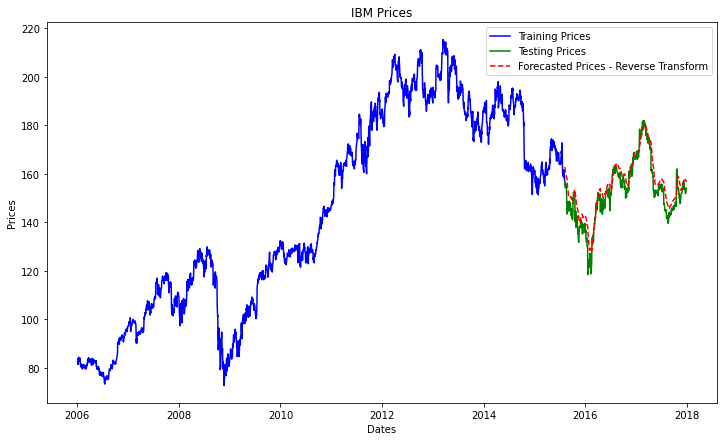

In [201]:
plt.figure(figsize=(12,7))
plt.title('IBM Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(train_series, color='blue', label='Training Prices')
plt.plot(test_series, color='green', label='Testing Prices')
plt.plot(predicted_stock_price_revtrans_series, color='red', linestyle='--', label='Forecasted Prices - Reverse Transform')
plt.legend();

### Q17: Visualize only test and forecast prices

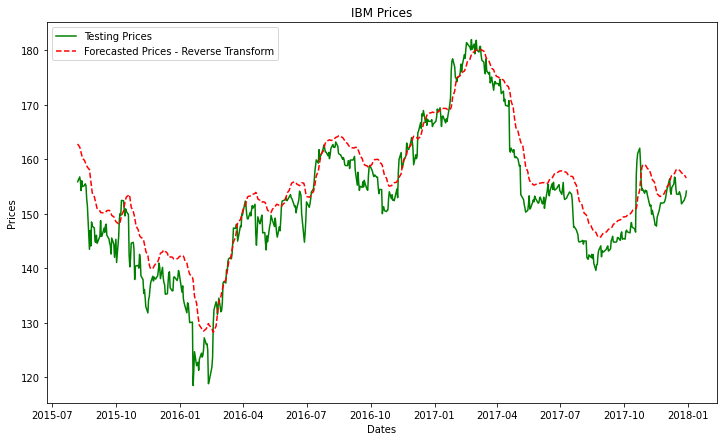

In [202]:
plt.figure(figsize=(12,7))
plt.title('IBM Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(test_series, color='green', label='Testing Prices')
plt.plot(predicted_stock_price_revtrans_series, color='red', linestyle='--', label='Forecasted Prices - Reverse Transform')
plt.legend();

# Conclusion

Remember we did a rolling point-based prediction for the ARIMA model where we tried to predict every day's (t) stock price in the test data by using both the training data as well as the previous (n - t) days of test data also to fit the model which gave it such good results vs. the LSTM model where we used 2 months of rolling window price data to predict the next day's price.